In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

### Functions used in this code
import density_functions as dfunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
clnr = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-9999.0)&(r13['LOGG']>0.0)&\
                (r13['M_H_ERR']>-90.0)&(r13['C_FE']>-9999.0)&(r13['N_FE']>-9999.0))

r13 = r13[clnr]

#Transform APOGEE RA and DEC to Magellanic Stream L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

In [3]:
##############
### Fields ###
##############

field_str = ['30Dor','LMC1','LMC2','LMC3','LMC4','LMC5','LMC6','LMC7','LMC8','LMC9','LMC10','LMC11','LMC12',
             'LMC13','LMC14','LMC15','LMC16','LMC17']

In [4]:
### blue loop cut
bloop = np.where((r13['TEFF']>=4100)&(r13['H']<=13.0)&((r13['J']-r13['K'])<=0.95))

bloop_cut = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    if i not in np.squeeze(bloop).tolist():
        bloop_cut.append(i)
        
bloopr13 = r13[bloop_cut]

fields = []
for i in range(len(field_str)):
    fields.append(np.where(bloopr13['FIELD']==field_str[i]))

In [5]:
def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

In [6]:
import statsmodels.api as sm

def ols_fit(x,y):
    '''
    Calculate OLS fit of a line aking use of statsmodels.api
    
    Parameters:
    ----------
        x: exog of line
        y: endog of line
    
    Returns:
    -------
        m: slope of OLS line
        b: intercept of OLS line
    '''
    
    # fit model
    model = np.array([x]).T
    model = sm.add_constant(model)
    model_fit = sm.OLS(y,model).fit()
    err = model_fit.bse[::-1]
    m = model_fit.params[1]
    b = model_fit.params[0]
    
    return m, b, err

<font size='20'>
    <b>
        AGES
    </b>
</font>

In [7]:
### Model
def find_ages(z1,z2,z3):
    p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
         1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
    return age

#     p = [9.38559303e+00,4.50640684e-02,-6.04245546e-02,-2.97525149e+00,1.89919586e-02,-5.42190398e-02,
#          1.09839708e-01,-5.88914872e-03,2.50980954e-02,8.74102230e-01,2.28289124e-02]
    
#     age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
#            p[7]*np.square(z1)+p[8]*np.square(z2)+p[9]*np.square(z3)+p[10]*(z3**3))
#     return ages

### PCA 
from sklearn.decomposition import PCA
pdat = np.array([parsec['logTe'],parsec['Ksmag'],np.log10(parsec['Zini']/0.02),parsec['logg']]).T


### Solar X
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(r13)):
    x_C.append(sol_xm[0]*10**(r13['C_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_N.append(sol_xm[1]*10**(r13['N_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_O.append(sol_xm[2]*10**(r13['O_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Mg.append(sol_xm[3]*10**(r13['Mg_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Ca.append(sol_xm[4]*10**(r13['Ca_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_S.append(sol_xm[5]*10**(r13['S_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Si.append(sol_xm[6]*10**(r13['SI_FE'][i]+r13['FE_H'][i]-r13['M_H'][i]))
    x_Fe.append(sol_xm[7]*10**(r13['FE_H'][i]-r13['M_H'][i]))

In [8]:
####################################
### Get Uncertainties: Add Noise ###
####################################

def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

def sal_noise(cfe,cfeERR,nfe,nfeERR,feh,fehERR,mh,mhERR):
    '''
    Calculate noisy values for Salaris calculation with C and N.
    This does not take into account actually plugging in [M/H],
    for that use add_noise.
    
    Parameters:
        cfe: 1d array-like object of carbon abundances
        cfeERR: 1d array-like object of carbon abundance errors
        nfe: 1d array-like object of nitrogen abundances
        nfeERR: 1d array-like object of nitrogen abundance errors
        feh: 1d array-like object of iron abundances
        fehERR: 1d array-like object of iron abundance errors
        
    Return:
        noisy Salaris correction ffac
    '''
    
    sol_C = 0.28115244582676185 #solar carbon abundance
    sol_N = 0.06901474154376043 #solar nitrogen abundance
    
    # Calculate [C/M] and [N/M] with respective errors
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    # Calculate X fractions for C and N with respective errors
    x_C = sol_C*10**(cm)
    x_N = sol_N*10**(nm)
    
    x_CERR = 10**(cm)*np.log(10)*CMERR
    x_NERR = 10**(nm)*np.log(10)*NMERR
    
    # Calcuate f factor in Salaris correction with respective errors
    ffac = (x_C+x_N)/(sol_C+sol_N) #factor from Salaris correction
    ffacERR = np.sqrt((x_CERR)**2+(x_NERR)**2)/(sol_C+sol_N)
    
    # Add noise to calculated f factor
    ffacnoise = np.random.uniform(-np.absolute(0.434*(ffacERR/ffac)),np.absolute(0.434*(ffacERR/ffac))) 
    
    return ffac + ffacnoise

In [9]:
age_dist = []

pca_transform = PCA(n_components=3).fit(pdat)

for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    # temperature
    teff = r13['TEFF'][i]
    teff_err = r13['TEFF_ERR'][i]
    
    # photometry 
    ra = r13['RA'][i]
    dec = r13['DEC'][i]
    ks = r13['K'][i]
    ks_err = r13['K_ERR'][i]
    ak = r13['AK_TARG'][i]
    
    # abundances
    mh = r13['M_H'][i]
    mh_err = r13['M_H_ERR'][i]
    cfe = r13['C_FE'][i]
    cfe_err = r13['C_FE_ERR'][i]
    nfe = r13['N_FE'][i]
    nfe_err = r13['N_FE_ERR'][i]
    feh = r13['FE_H'][i]
    feh_err = r13['FE_H_ERR'][i]
    
    # surface gravity
    lgg = r13['LOGG'][i]
    lgg_err = r13['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(1000):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        _, _, dist = dfunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
            
        absK_new = dfunc.absmag(ks_new,dist) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,dfunc.sal(mh_new,ffac_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(find_ages(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in range(len(age_dist)):
    devs.append(dfunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
    
bloopage = np.asarray(parages)[bloop_cut]
bloopage_devs = np.asarray(devs)[bloop_cut]

xLMC,yLMC,stardist = dfunc.LMCdisk_cart(r13['RA'],r13['DEC'])
ell_over = elliptical_radius(xLMC,yLMC)
bloopabsH = (dfunc.absmag(r13['H'],stardist)-r13['AK_TARG'])[bloop_cut]

AttributeError: module 'density_functions' has no attribute 'LMCdisk_cart'

In [ ]:
young = np.where(bloopage<=np.log10(0.5*10**9))
yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9)))
ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9)))
omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9)))
old = np.where(bloopage>np.log10(10.5*10**9))

In [ ]:
len(np.squeeze(young))

<font size='20'>
    <b>
        Field Area
    </b>
</font>

In [14]:
### pc^2
field_ang = [0.8,0.95,0.95,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.95,0.8,0.8,0.8,0.95,0.8]
field_areas = np.multiply(np.pi*np.square(np.multiply(field_ang,0.875)),10**6)

<font size='20'>
    <b>
        Field Mass
    </b>
</font>

In [15]:
iso_ages = []
iso_zs = []

#fnt and brt bins
fbins = dfunc.brtfntlmc_bins(bloopr13)

for i in range(len(field_str)):
    fd = np.where(bloopr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(bloopage[fd]),np.median(bloopr13[fd]['FE_H']))
    iso_ages.append(age)
    iso_zs.append(z)

absHs = []
for i in range(len(field_str)):
    field_H = np.where(bloopr13['FIELD']==field_str[i]) 
    absHs.append(np.asarray(bloopabsH)[field_H])

sf_brites = []
sf_faints = []

for i in field_str:
    fld = np.where(bloopr13['FIELD']==i)
    
    fnts = np.where(bloopr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(bloopr13['TARGET_NAME'][fld]=='BrtRGB')
    
    sf_faints.append(bloopr13['SELECTFUNC'][fld][fnts])
    sf_brites.append(bloopr13['SELECTFUNC'][fld][brts])

field_masses = []
for i in range(len(field_str)):
    field_masses.append(dfunc.fieldmass(iso_ages[i],iso_zs[i],absHs[i],sf_brites[i],sf_faints[i],parsec))
print(field_masses)

[38948125.475158095, 3859148.1085739634, 2749102.569200976, 16543977.321322989, 75439435.33564752, 69191221.97639048, 45379959.403296314, 15723476.972983105, 58850869.21661246, 300166064.3654617, 10990568.431081766, 30064415.863535218, 2177713.3526685145, 56103250.367853664, 84139038.15849002, 14160105.209683018, 3109445.759382547, 15991617.18526346]


<font size='20'>
    <b>
        Density Calculation 30 Dor rm
    </b>
</font>

In [16]:
### Calculate Surface Densities and Density Profile

import statsmodels.api as sm

surfden = []
for i in range(len(field_masses)):
    surfden.append(np.divide(field_masses[i],field_areas[i]))
    
'''
model is sigma = A*exp(B*r)
A central density 
B radial scale height 
r radius

ln(sigma) = lnA + B*r
'''

import statsmodels.api as sm 

field_list = [np.where(bloopr13['FIELD']=='30Dor'),np.where(bloopr13['FIELD']=='LMC1'),
              np.where(bloopr13['FIELD']=='LMC2'),np.where(bloopr13['FIELD']=='LMC3'),
              np.where(bloopr13['FIELD']=='LMC4'),np.where(bloopr13['FIELD']=='LMC5'),
              np.where(bloopr13['FIELD']=='LMC6'),np.where(bloopr13['FIELD']=='LMC7'),
              np.where(bloopr13['FIELD']=='LMC8'),np.where(bloopr13['FIELD']=='LMC9'),
              np.where(bloopr13['FIELD']=='LMC10'),np.where(bloopr13['FIELD']=='LMC11'),
              np.where(bloopr13['FIELD']=='LMC12'),np.where(bloopr13['FIELD']=='LMC13'),
              np.where(bloopr13['FIELD']=='LMC14'),np.where(bloopr13['FIELD']=='LMC15'),
              np.where(bloopr13['FIELD']=='LMC16'),np.where(bloopr13['FIELD']=='LMC17')]

radii = []
for i in range(len(field_str)):
    radii.append(np.median(ell_over[field_list[i]]))

1.3476228161816035 +/- 0.3395424752238693


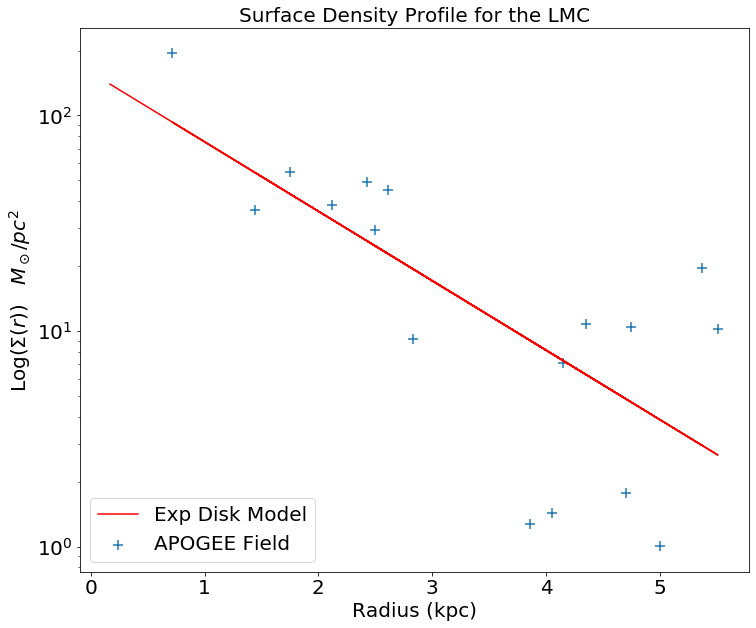

In [17]:
radii_rm30dor = np.delete(radii,0)
surfden_rm30dor = np.delete(surfden,0)

m, b,err = ols_fit(radii_rm30dor,np.log(surfden_rm30dor))
print(str(-1./m)+ ' +/- ' + str(err[0]/(m**2)))

def lmcdensityprofile_rm30dor(r):
    return b+np.multiply(m,r)

plt.figure(figsize=[12,10])

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)

plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('lmcdensityprofile_rm30dor.pdf',bbox_inches='tight')
plt.show()

<font size='20'>
    <b>
        Metallicity Bins
    </b>
</font>

In [18]:
metal_poor = np.where(bloopr13['FE_H']<-0.87833154)
m_int1 = np.where((bloopr13['FE_H']>=-0.87833154)&(bloopr13['FE_H']<-0.7067915))
m_int2 = np.where((bloopr13['FE_H']>=-0.7067915)&(bloopr13['FE_H']<-0.5933316))
metal_rich = np.where(bloopr13['FE_H']>=-0.5933316)

#Metal Poor
mpr13 = bloopr13[metal_poor]
mpages = bloopage[metal_poor]
mpabsH = bloopabsH[metal_poor]

#Metal Intermediate 1
mint1r13 = bloopr13[m_int1]
mint1ages = bloopage[m_int1]
mint1absH = bloopabsH[m_int1]

#Metal Intermediate 2
mint2r13 = bloopr13[m_int2]
mint2ages = bloopage[m_int2]
mint2absH = bloopabsH[m_int2]

#Metal Rich
mrr13 = bloopr13[metal_rich]
mrages = bloopage[metal_rich]
mrabsH = bloopabsH[metal_rich]

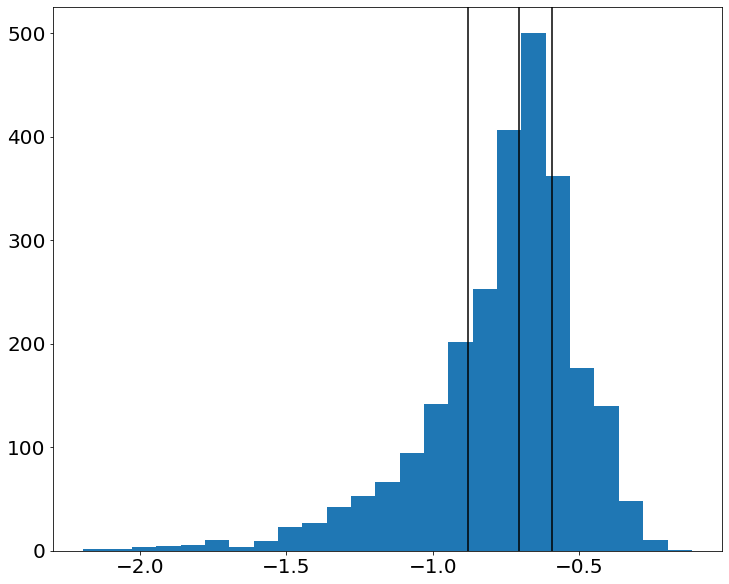

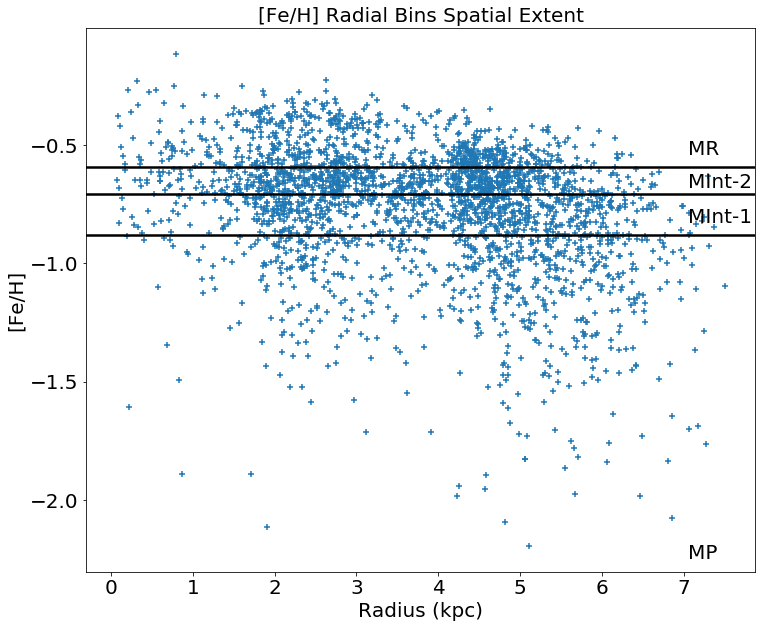

In [19]:
## Metallicity histogram with bins
plt.figure(figsize=[12,10])
plt.hist(r13['FE_H'],bins=25)
plt.axvline(-0.87833154,c='k')
plt.axvline(-0.7067915,c='k')
plt.axvline(-0.5933316,c='k')
plt.show()

## Metallicity as function of radius
plt.figure(figsize=[12,10])
plt.scatter(np.sqrt(xLMC**2+yLMC**2),r13['FE_H'],marker='+',c='tab:blue')
plt.axhline(-0.87833154,c='k',lw=2.5)
plt.axhline(-0.7067915,c='k',lw=2.5)
plt.axhline(-0.5933316,c='k',lw=2.5)

plt.title(r'[Fe/H] Radial Bins Spatial Extent',fontsize=20)

plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'[Fe/H]',fontsize=20)

plt.text(7.05,-0.5933316+0.05,'MR',fontsize=20)
plt.text(7.05,-0.7067915+0.025,'MInt-2',fontsize=20)
plt.text(7.05,-0.87833154+0.05,'MInt-1',fontsize=20)
plt.text(7.05,-2.25,'MP',fontsize=20)
plt.show()

## Metal Poor

In [20]:
mp_iso_ages = []
mp_iso_zs = []

#fnt and brt bins
mp_fbins = dfunc.brtfntlmc_bins(mpr13)

for i in range(len(field_str)):
    fd = np.where(mpr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mpages[fd]),np.median(mpr13[fd]['FE_H']))
    mp_iso_ages.append(age)
    mp_iso_zs.append(z)

mp_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mpr13['FIELD']==field_str[i]) 
    mp_absHs.append(np.asarray(mpabsH)[field_H])

mp_sf_brites = []
mp_sf_faints = []

for i in field_str:
    fld = np.where(mpr13['FIELD']==i)
    
    fnts = np.where(mpr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mpr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mp_sf_faints.append(mpr13['SELECTFUNC'][fld][fnts])
    mp_sf_brites.append(mpr13['SELECTFUNC'][fld][brts])
        
mp_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mp_field_masses.append(dfunc.fieldmass(mp_iso_ages[i],mp_iso_zs[i],mp_absHs[i],mp_sf_brites[i],
                                               mp_sf_faints[i],parsec))
    except:
        mp_field_masses.append(-9999.0)
        
for i in range(len(mp_field_masses)):
    if np.isfinite(mp_field_masses[i]) == False:
        mp_field_masses[i] = -9999.0

In [21]:
mp_field_masses

[-9999.0,
 1504532.2761609673,
 1393264.4873126578,
 2920823.174837127,
 3936249.871320137,
 18406594.905885253,
 10617092.052957999,
 4783366.783001381,
 12215610.841002597,
 59167602.31726517,
 2091833.3916599855,
 5814033.024952444,
 1046363.6860482243,
 10747974.154954005,
 21028468.084006328,
 2974877.4146886724,
 1456350.6053616263,
 5243800.50667527]

1.3908637088017746 +/- 0.3616817126879569


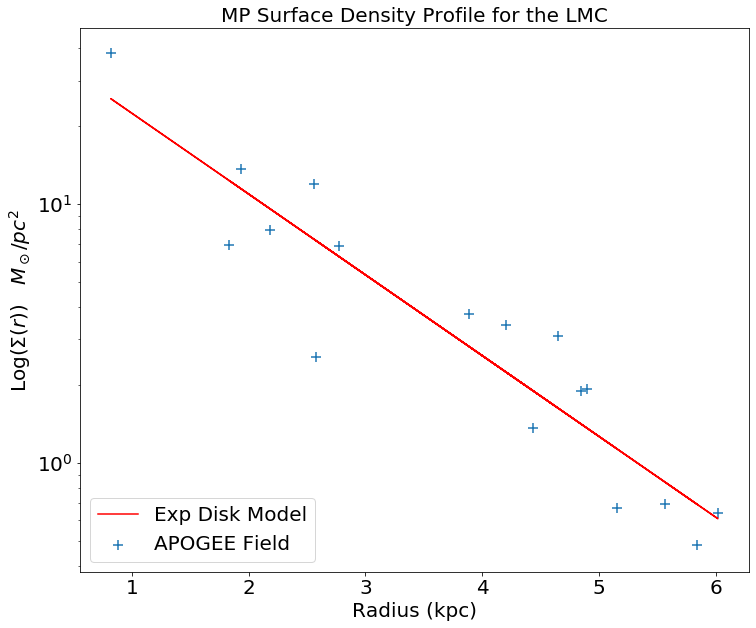

In [22]:
mp_surfden = []
for i in range(len(mp_field_masses)):
    mp_surfden.append(np.divide(mp_field_masses[i],field_areas[i]))

field_list = [np.where(mpr13['FIELD']=='30Dor'),np.where(mpr13['FIELD']=='LMC1'),
              np.where(mpr13['FIELD']=='LMC2'),np.where(mpr13['FIELD']=='LMC3'),
              np.where(mpr13['FIELD']=='LMC4'),np.where(mpr13['FIELD']=='LMC5'),
              np.where(mpr13['FIELD']=='LMC6'),np.where(mpr13['FIELD']=='LMC7'),
              np.where(mpr13['FIELD']=='LMC8'),np.where(mpr13['FIELD']=='LMC9'),
              np.where(mpr13['FIELD']=='LMC10'),np.where(mpr13['FIELD']=='LMC11'),
              np.where(mpr13['FIELD']=='LMC12'),np.where(mpr13['FIELD']=='LMC13'),
              np.where(mpr13['FIELD']=='LMC14'),np.where(mpr13['FIELD']=='LMC15'),
              np.where(mpr13['FIELD']=='LMC16'),np.where(mpr13['FIELD']=='LMC17')]

mp_radii = []

x_mp, y_mp, _ = dfunc.LMCdisk_cart(mpr13['RA'],mpr13['DEC'])
ell_mp = elliptical_radius(x_mp,y_mp)
for i in range(len(field_str)):
    
    mp_radii.append(np.median(ell_mp[field_list[i]]))
    
good = np.where(np.asarray(mp_surfden)>0.0)

mp_radii = np.asarray(mp_radii)[good]
mp_surfden = np.asarray(mp_surfden)[good]


mp_m, mp_b,mp_err = ols_fit(mp_radii,np.log(mp_surfden))
print(str(-1./mp_m)+ ' +/- ' + str(err[0]/(mp_m**2)))

def mpprofile(r):
    return mp_b+np.multiply(mp_m,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mp_radii,mp_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('MP Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mpprofile.pdf',bbox_inches='tight')
plt.show()

## Metal Int 1

In [23]:
mint1_iso_ages = []
mint1_iso_zs = []

#fnt and brt bins
mint1_fbins = dfunc.brtfntlmc_bins(mint1r13)

for i in range(len(field_str)):
    fd = np.where(mint1r13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mint1ages[fd]),np.median(mint1r13[fd]['FE_H']))
    mint1_iso_ages.append(age)
    mint1_iso_zs.append(z)

mint1_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint1r13['FIELD']==field_str[i]) 
    mint1_absHs.append(np.asarray(mint1absH)[field_H])

mint1_sf_brites = []
mint1_sf_faints = []

for i in field_str:
    fld = np.where(mint1r13['FIELD']==i)
    
    fnts = np.where(mint1r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint1r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint1_sf_faints.append(mint1r13['SELECTFUNC'][fld][fnts])
    mint1_sf_brites.append(mint1r13['SELECTFUNC'][fld][brts])
        
mint1_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint1_field_masses.append(dfunc.fieldmass(mint1_iso_ages[i],mint1_iso_zs[i],mint1_absHs[i],mint1_sf_brites[i],
                                               mint1_sf_faints[i],parsec))
    except:
        mint1_field_masses.append(-9999.0)
        
for i in range(len(mint1_field_masses)):
    if np.isfinite(mint1_field_masses[i]) == False:
        mint1_field_masses[i] = -9999.0

1.2888301628684065 +/- 0.31056233448750964


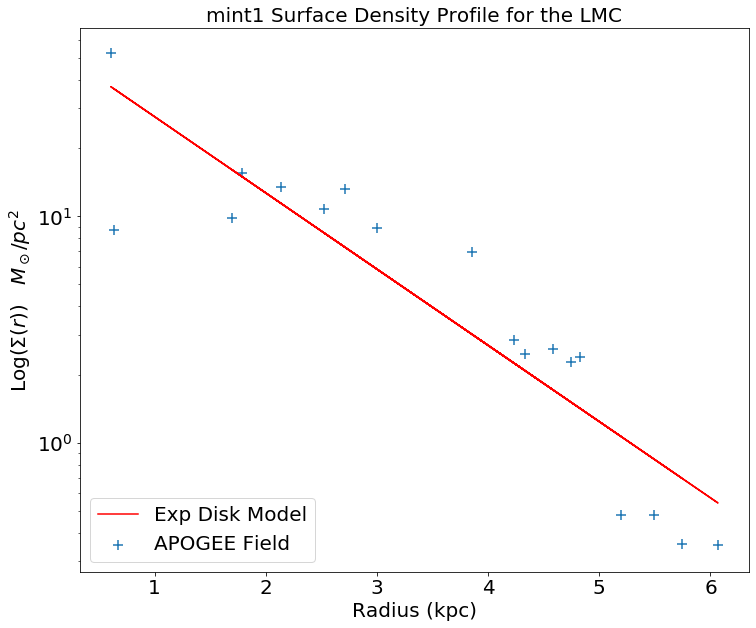

In [24]:
mint1_surfden = []
for i in range(len(mint1_field_masses)):
    mint1_surfden.append(np.divide(mint1_field_masses[i],field_areas[i]))

field_list = [np.where(mint1r13['FIELD']=='30Dor'),np.where(mint1r13['FIELD']=='LMC1'),
              np.where(mint1r13['FIELD']=='LMC2'),np.where(mint1r13['FIELD']=='LMC3'),
              np.where(mint1r13['FIELD']=='LMC4'),np.where(mint1r13['FIELD']=='LMC5'),
              np.where(mint1r13['FIELD']=='LMC6'),np.where(mint1r13['FIELD']=='LMC7'),
              np.where(mint1r13['FIELD']=='LMC8'),np.where(mint1r13['FIELD']=='LMC9'),
              np.where(mint1r13['FIELD']=='LMC10'),np.where(mint1r13['FIELD']=='LMC11'),
              np.where(mint1r13['FIELD']=='LMC12'),np.where(mint1r13['FIELD']=='LMC13'),
              np.where(mint1r13['FIELD']=='LMC14'),np.where(mint1r13['FIELD']=='LMC15'),
              np.where(mint1r13['FIELD']=='LMC16'),np.where(mint1r13['FIELD']=='LMC17')]

mint1_radii = []

x_mint1, y_mint1, _ = dfunc.LMCdisk_cart(mint1r13['RA'],mint1r13['DEC'])
ell_mint1 = elliptical_radius(x_mint1,y_mint1)
for i in range(len(field_str)):
    
    mint1_radii.append(np.median(ell_mint1[field_list[i]]))
    
good = np.where(np.asarray(mint1_surfden)>0.0)

mint1_radii = np.asarray(mint1_radii)[good]
mint1_surfden = np.asarray(mint1_surfden)[good]


mint1_m, mint1_b,mint1_err = ols_fit(mint1_radii,np.log(mint1_surfden))
print(str(-1./mint1_m)+ ' +/- ' + str(err[0]/(mint1_m**2)))

def mint1profile(r):
    return mint1_b+np.multiply(mint1_m,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mint1_radii,mint1_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mint1 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint1profile.pdf',bbox_inches='tight')
plt.show()

## Metal Int 2

In [25]:
mint2_iso_ages = []
mint2_iso_zs = []

#fnt and brt bins
mint2_fbins = dfunc.brtfntlmc_bins(mint2r13)

for i in range(len(field_str)):
    fd = np.where(mint2r13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mint2ages[fd]),np.median(mint2r13[fd]['FE_H']))
    mint2_iso_ages.append(age)
    mint2_iso_zs.append(z)

mint2_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mint2r13['FIELD']==field_str[i]) 
    mint2_absHs.append(np.asarray(mint2absH)[field_H])

mint2_sf_brites = []
mint2_sf_faints = []

for i in field_str:
    fld = np.where(mint2r13['FIELD']==i)
    
    fnts = np.where(mint2r13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mint2r13['TARGET_NAME'][fld]=='BrtRGB')
    
    mint2_sf_faints.append(mint2r13['SELECTFUNC'][fld][fnts])
    mint2_sf_brites.append(mint2r13['SELECTFUNC'][fld][brts])
        
mint2_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mint2_field_masses.append(dfunc.fieldmass(mint2_iso_ages[i],mint2_iso_zs[i],mint2_absHs[i],mint2_sf_brites[i],
                                               mint2_sf_faints[i],parsec))
    except:
        mint2_field_masses.append(-9999.0)
        
for i in range(len(mint2_field_masses)):
    if np.isfinite(mint2_field_masses[i]) == False:
        mint2_field_masses[i] = -9999.0

1.2447552964910926 +/- 0.28968457155108224


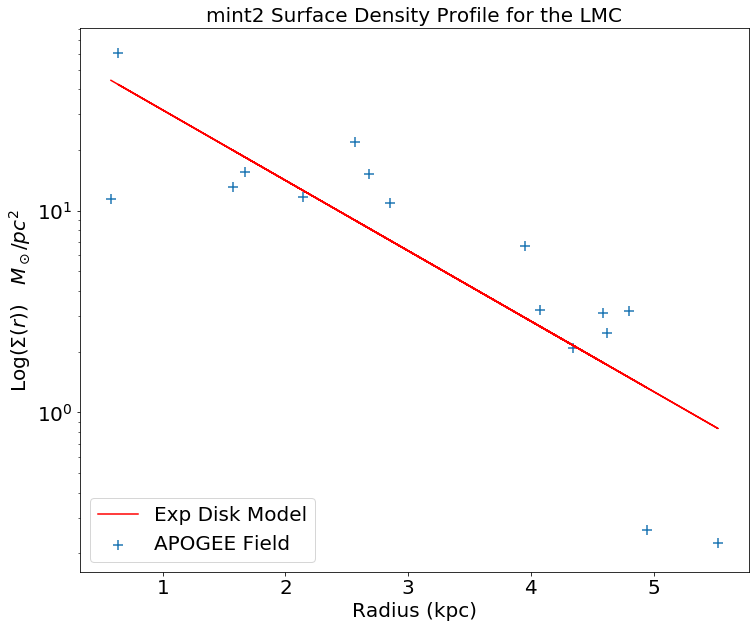

In [26]:
mint2_surfden = []
for i in range(len(mint2_field_masses)):
    mint2_surfden.append(np.divide(mint2_field_masses[i],field_areas[i]))

field_list = [np.where(mint2r13['FIELD']=='30Dor'),np.where(mint2r13['FIELD']=='LMC1'),
              np.where(mint2r13['FIELD']=='LMC2'),np.where(mint2r13['FIELD']=='LMC3'),
              np.where(mint2r13['FIELD']=='LMC4'),np.where(mint2r13['FIELD']=='LMC5'),
              np.where(mint2r13['FIELD']=='LMC6'),np.where(mint2r13['FIELD']=='LMC7'),
              np.where(mint2r13['FIELD']=='LMC8'),np.where(mint2r13['FIELD']=='LMC9'),
              np.where(mint2r13['FIELD']=='LMC10'),np.where(mint2r13['FIELD']=='LMC11'),
              np.where(mint2r13['FIELD']=='LMC12'),np.where(mint2r13['FIELD']=='LMC13'),
              np.where(mint2r13['FIELD']=='LMC14'),np.where(mint2r13['FIELD']=='LMC15'),
              np.where(mint2r13['FIELD']=='LMC16'),np.where(mint2r13['FIELD']=='LMC17')]

mint2_radii = []

x_mint2, y_mint2, _ = dfunc.LMCdisk_cart(mint2r13['RA'],mint2r13['DEC'])
ell_mint2 = elliptical_radius(x_mint2,y_mint2)
for i in range(len(field_str)):
    
    mint2_radii.append(np.median(ell_mint2[field_list[i]]))
    
good = np.where(np.asarray(mint2_surfden)>0.0)

mint2_radii = np.asarray(mint2_radii)[good]
mint2_surfden = np.asarray(mint2_surfden)[good]


mint2_m, mint2_b,mint2_err = ols_fit(mint2_radii,np.log(mint2_surfden))
print(str(-1./mint2_m)+ ' +/- ' + str(err[0]/(mint2_m**2)))

def mint2profile(r):
    return mint2_b+np.multiply(mint2_m,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mint2_radii,mint2_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mint2 Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mint2profile.pdf',bbox_inches='tight')
plt.show()

## Metal Rich

In [27]:
mr_iso_ages = []
mr_iso_zs = []

#fnt and brt bins
mr_fbins = dfunc.brtfntlmc_bins(mrr13)

for i in range(len(field_str)):
    fd = np.where(mrr13['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(mrages[fd]),np.median(mrr13[fd]['FE_H']))
    mr_iso_ages.append(age)
    mr_iso_zs.append(z)

mr_absHs = []
for i in range(len(field_str)):
    field_H = np.where(mrr13['FIELD']==field_str[i]) 
    mr_absHs.append(np.asarray(mrabsH)[field_H])

mr_sf_brites = []
mr_sf_faints = []

for i in field_str:
    fld = np.where(mrr13['FIELD']==i)
    
    fnts = np.where(mrr13['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(mrr13['TARGET_NAME'][fld]=='BrtRGB')
    
    mr_sf_faints.append(mrr13['SELECTFUNC'][fld][fnts])
    mr_sf_brites.append(mrr13['SELECTFUNC'][fld][brts])
        
mr_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        mr_field_masses.append(dfunc.fieldmass(mr_iso_ages[i],mr_iso_zs[i],mr_absHs[i],mr_sf_brites[i],
                                               mr_sf_faints[i],parsec))
    except:
        mr_field_masses.append(-9999.0)
        
for i in range(len(mr_field_masses)):
    if np.isfinite(mr_field_masses[i]) == False:
        mr_field_masses[i] = -9999.0

1.2510661841283217 +/- 0.29262940926064307


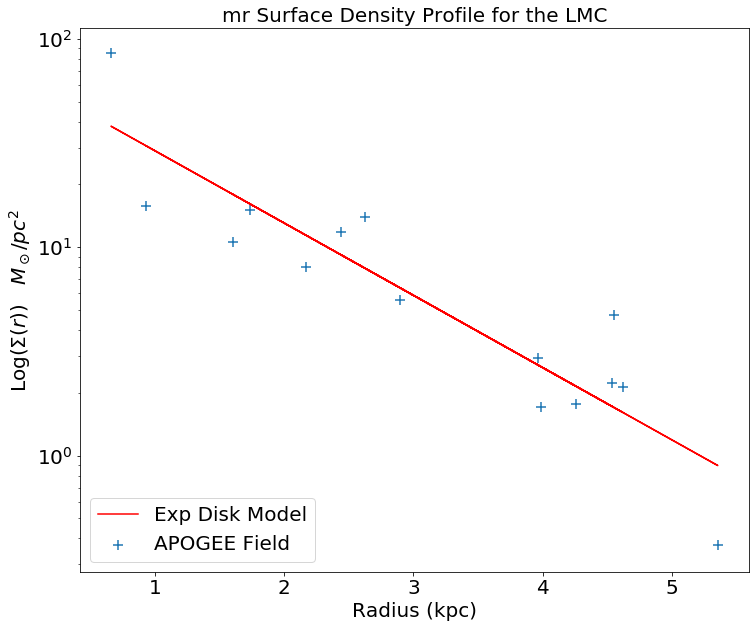

In [28]:
mr_surfden = []
for i in range(len(mr_field_masses)):
    mr_surfden.append(np.divide(mr_field_masses[i],field_areas[i]))

field_list = [np.where(mrr13['FIELD']=='30Dor'),np.where(mrr13['FIELD']=='LMC1'),
              np.where(mrr13['FIELD']=='LMC2'),np.where(mrr13['FIELD']=='LMC3'),
              np.where(mrr13['FIELD']=='LMC4'),np.where(mrr13['FIELD']=='LMC5'),
              np.where(mrr13['FIELD']=='LMC6'),np.where(mrr13['FIELD']=='LMC7'),
              np.where(mrr13['FIELD']=='LMC8'),np.where(mrr13['FIELD']=='LMC9'),
              np.where(mrr13['FIELD']=='LMC10'),np.where(mrr13['FIELD']=='LMC11'),
              np.where(mrr13['FIELD']=='LMC12'),np.where(mrr13['FIELD']=='LMC13'),
              np.where(mrr13['FIELD']=='LMC14'),np.where(mrr13['FIELD']=='LMC15'),
              np.where(mrr13['FIELD']=='LMC16'),np.where(mrr13['FIELD']=='LMC17')]

mr_radii = []

x_mr, y_mr, _ = dfunc.LMCdisk_cart(mrr13['RA'],mrr13['DEC'])
ell_mr = elliptical_radius(x_mr,y_mr)
for i in range(len(field_str)):
    
    mr_radii.append(np.median(ell_mr[field_list[i]]))
    
good = np.where(np.asarray(mr_surfden)>0.0)

mr_radii = np.asarray(mr_radii)[good]
mr_surfden = np.asarray(mr_surfden)[good]


mr_m, mr_b,mr_err = ols_fit(mr_radii,np.log(mr_surfden))
print(str(-1./mr_m)+ ' +/- ' + str(err[0]/(mr_m**2)))

def mrprofile(r):
    return mr_b+np.multiply(mr_m,r)

rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
              'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

plt.figure(figsize=[12,10])

plt.scatter(mr_radii,mr_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='r',label='Exp Disk Model')
plt.yscale('log')
plt.xlabel(r'Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('mr Surface Density Profile for the LMC',fontsize=20)
plt.legend(loc='lower left',fontsize=20)
plt.savefig('mrprofile.pdf',bbox_inches='tight')
plt.show()

## All [Fe/H] Profiles Together

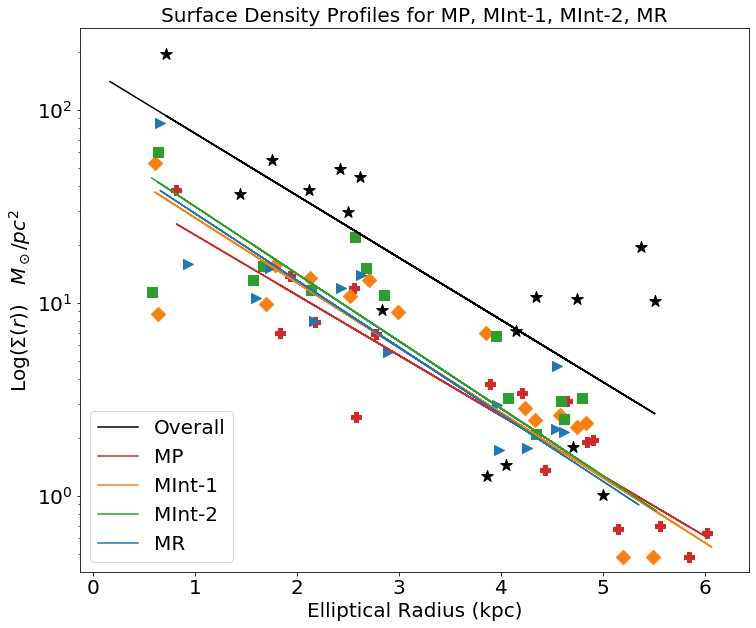

In [29]:
plt.figure(figsize=[12,10])

plt.plot(radii,np.exp(lmcdensityprofile_rm30dor(radii)),c='k',label='Overall')
plt.plot(mp_radii,np.exp(mpprofile(mp_radii)),c='tab:red',label='MP')
plt.plot(mint1_radii,np.exp(mint1profile(mint1_radii)),c='tab:orange',label='MInt-1')
plt.plot(mint2_radii,np.exp(mint2profile(mint2_radii)),c='tab:green',label='MInt-2')
plt.plot(mr_radii,np.exp(mrprofile(mr_radii)),c='tab:blue',label='MR')

plt.legend(loc='lower left',fontsize=20)

plt.scatter(radii_rm30dor,surfden_rm30dor,marker='*',c='k',s=150)
plt.scatter(mp_radii,mp_surfden,marker='P',c='tab:red',s=100)
plt.scatter(mint1_radii,mint1_surfden,marker='D',c='tab:orange',s=100)
plt.scatter(mint2_radii,mint2_surfden,marker='s',c='tab:green',s=100)
plt.scatter(mr_radii,mr_surfden,marker='>',c='tab:blue',s=100)

# plt.ylim(bottom=1)

plt.yscale('log')
plt.xlabel(r'Elliptical Radius (kpc)',fontsize=20)
plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
plt.title('Surface Density Profiles for MP, MInt-1, MInt-2, MR',fontsize=20)

plt.savefig('allprofiles',bbox_inches='tight')
plt.show()

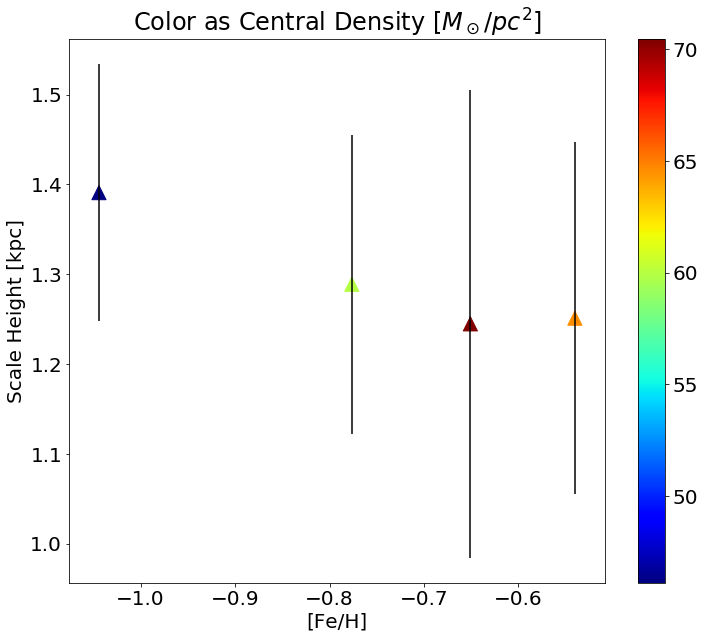

In [30]:
medage = [np.median(bloopr13[metal_poor]['FE_H']),np.median(bloopr13[m_int1]['FE_H']),
          np.median(bloopr13[m_int2]['FE_H']),np.median(bloopr13[metal_rich]['FE_H']),]

heights = [-np.reciprocal(mp_m),-np.reciprocal(mint1_m),-np.reciprocal(mint2_m),-np.reciprocal(mr_m)]

heights_err = [mp_err[0]/(mp_m)**2,mint1_err[0]/(mp_m)**2,mint2_err[0]/(mp_m)**2,mr_err[0]/(mp_m)**2]

cen_den = [np.exp(mp_b),np.exp(mint1_b),np.exp(mint2_b),np.exp(mr_b)]

plt.figure(figsize=[12,10])
plt.errorbar(medage,heights,yerr=heights_err,c='k',ls='none')
plt.scatter(medage,heights,marker='^',s=200,c=cen_den,cmap='jet')
plt.colorbar()
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Scale Height [kpc]')
plt.title(r'Color as Central Density [$M_\odot/pc^2$]')
plt.savefig('feh_scale.png',bbox_inches='tight')
plt.show()

<font size='20'>
    <b>
        Age Bins
    </b>
</font>

In [31]:
young = np.where(bloopage<=np.log10(0.5*10**9))
yless = np.where((bloopage>np.log10(0.5*10**9))&(bloopage<=np.log10(2.0*10**9)))
ymed = np.where((bloopage>np.log10(2.0*10**9))&(bloopage<=np.log10(7*10**9)))
omed = np.where((bloopage>np.log10(7*10**9))&(bloopage<=np.log10(10.5*10**9)))
old = np.where(bloopage>np.log10(10.5*10**9))

r13young = bloopr13[young]
r13yless = bloopr13[yless]
r13ymed = bloopr13[ymed]
r13omed = bloopr13[omed]
r13old = bloopr13[old]

In [32]:
len(r13young)

33

## Young

In [ ]:
young_iso_ages = []
young_iso_zs = []

#fnt and brt bins
young_fbins = dfunc.brtfntlmc_bins(r13young)

for i in range(len(field_str)):
    fd = np.where(r13young['FIELD']==field_str[i])
    age, z = dfunc.findclosestparsec(parsec,np.median(np.asarray(parages)[young][fd]),
                                     np.median(r13young[fd]['FE_H']))
    young_iso_ages.append(age)
    young_iso_zs.append(z)

young_absHs = []
for i in range(len(field_str)):
    field_H = np.where(r13young['FIELD']==field_str[i]) 
    young_absHs.append(np.asarray(bloopabsH[young])[field_H])

young_sf_brites = []
young_sf_faints = []

for i in field_str:
    fld = np.where(r13young['FIELD']==i)
    
    fnts = np.where(r13young['TARGET_NAME'][fld]=='FntRGB')
    brts = np.where(r13young['TARGET_NAME'][fld]=='BrtRGB')
    
    young_sf_faints.append(r13young['SELECTFUNC'][fld][fnts])
    young_sf_brites.append(r13young['SELECTFUNC'][fld][brts])
        
young_field_masses = []
for i in tqdm_notebook(range(len(field_str)),desc='done?'):
    try:
        young_field_masses.append(dfunc.fieldmass(young_iso_ages[i],young_iso_zs[i],young_absHs[i],
                                                  young_sf_brites[i],young_sf_faints[i],parsec))
    except:
        young_field_masses.append(-9999.0)
        
for i in range(len(young_field_masses)):
    if np.isfinite(young_field_masses[i]) == False:
        young_field_masses[i] = -9999.0

In [ ]:
young_surfden = []
for i in range(len(young_field_masses)):
    young_surfden.append(np.divide(young_field_masses[i],field_areas[i]))

field_list = [np.where(r13young['FIELD']=='30Dor'),np.where(r13young['FIELD']=='LMC1'),
              np.where(r13young['FIELD']=='LMC2'),np.where(r13young['FIELD']=='LMC3'),
              np.where(r13young['FIELD']=='LMC4'),np.where(r13young['FIELD']=='LMC5'),
              np.where(r13young['FIELD']=='LMC6'),np.where(r13young['FIELD']=='LMC7'),
              np.where(r13young['FIELD']=='LMC8'),np.where(r13young['FIELD']=='LMC9'),
              np.where(r13young['FIELD']=='LMC10'),np.where(r13young['FIELD']=='LMC11'),
              np.where(r13young['FIELD']=='LMC12'),np.where(r13young['FIELD']=='LMC13'),
              np.where(r13young['FIELD']=='LMC14'),np.where(r13young['FIELD']=='LMC15'),
              np.where(r13young['FIELD']=='LMC16'),np.where(r13young['FIELD']=='LMC17')]

young_radii = []

x_young, y_young, _ = dfunc.LMCdisk_cart(r13young['RA'],r13young['DEC'])
ell_young = elliptical_radius(x_young,y_young)
for i in range(len(field_str)):
    young_radii.append(np.median(ell_young[field_list[i]]))
    
good = np.where(np.asarray(young_surfden)>0.0)

young_radii = np.asarray(young_radii)[good]
young_surfden = np.asarray(young_surfden)[good]

young_m, young_b,young_err = ols_fit(young_radii,np.log(young_surfden))
print(str(-1./young_m)+ ' +/- ' + str(err[0]/(young_m**2)))

# def youngprofile(r):
#     return young_b+np.multiply(young_m,r)

# rad_labels = ['LMC1', 'LMC2', 'LMC3', 'LMC4', 'LMC5', 'LMC6', 'LMC7', 'LMC8','LMC9', 'LMC10', 'LMC11', 
#               'LMC12', 'LMC13', 'LMC14', 'LMC15','LMC16', 'LMC17']

# plt.figure(figsize=[12,10])

# plt.scatter(young_radii,young_surfden,marker='+',label='APOGEE Field',cmap='nipy_spectral',s=100)
# plt.plot(young_radii,np.exp(youngprofile(young_radii)),c='r',label='Exp Disk Model')
# plt.yscale('log')
# plt.xlabel(r'Radius (kpc)',fontsize=20)
# plt.ylabel(r'Log($\Sigma(r)$)   $M_\odot/pc^2$',fontsize=20)
# plt.title('young Surface Density Profile for the LMC',fontsize=20)
# plt.legend(loc='lower left',fontsize=20)
# plt.savefig('youngprofile.pdf',bbox_inches='tight')
# plt.show()

# print('central: {:.3f}'.format(np.exp(young_m)))
# print('scale: {:.3f}'.format(-np.reciprocal(young_b)))
# print('err: {:.3f}'.format(young_err[0]/(young_b)**2))

In [ ]:
young_field_masses